In [1]:
from bs4 import BeautifulSoup 
import urllib2 
import re 
from time import sleep 
from collections import Counter 
from nltk.corpus import stopwords 
import pandas as pd 
%matplotlib inline

In [2]:
def text_cleaner(website):
 
    try:
        site = urllib2.urlopen(website).read() 
    except: 
        return   
    
    soup_obj = BeautifulSoup(site) 
    
    for script in soup_obj(["script", "style"]):
        script.extract() 
    
    

    text = soup_obj.get_text() 
    
        
    
    lines = (line.strip() for line in text.splitlines()) 
    
        
        
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) 
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' 
        return chunk_out  
        
    
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') 
        
        
    
        
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') 
    except:                                                            
        return                                                         
       
        
    text = re.sub("[^a-zA-Z.+3]"," ", text) 
        
       
    text = text.lower().split()  
        
        
    stop_words = set(stopwords.words("english")) 
    text = [w for w in text if not w in stop_words]
        
        
        
    text = list(set(text)) 
                           
        
    return text

In [3]:
def skills_info(city = None, state = None):

    final_job = 'data+scientist' 
    
    
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] 
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) 

    
    base_url = 'http://www.indeed.com'
    
    
    try:
        html = urllib2.urlopen(final_site).read() 
    except:
        'That city/state combination did not have any jobs. Exiting . . .' 
        return
    soup = BeautifulSoup(html) 
    
    
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') 
                                                                        
    
    job_numbers = re.findall('\d+', num_jobs_area) 
    
    
    if len(job_numbers) > 3: 
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title 
    
    num_pages = total_num_jobs/10 
    
    job_descriptions = [] 
    
    for i in xrange(1,num_pages+1): 
        print 'Getting page', i
        start_num = str(i*10) 
        current_page = ''.join([final_site, '&start=', start_num])
        
            
        html_page = urllib2.urlopen(current_page).read() 
            
        page_obj = BeautifulSoup(html_page) 
        job_link_area = page_obj.find(id = 'resultsCol') 
            
        job_URLS = [(base_url + link.get('href')) if link.get('href') else base_url  for link in job_link_area.find_all('a')] # Get the URLS for the jobs
            
        job_URLS = filter(lambda x:'clk' in x, job_URLS) 
            
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: 
                job_descriptions.append(final_description)
            sleep(1) 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    
    doc_frequency = Counter() 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
   
    
  
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
    
    statistics_dict = Counter({'Statistics':doc_frequency['statistics'],  'A/B test':doc_frequency['A/B'],
                        'Optimization':doc_frequency['optimization'], 'Multivariate analysis':doc_frequency['mutivariate analysis'],
                        'Regression':doc_frequency['regression'], 'Random forest':doc_frequency['random forest']}) 
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict+statistics_dict 
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) 
    

    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) 
    

    
    final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)
    
# Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function
        
   

In [4]:
cities=['New York','Boston','Los Angeles','San Francisco','San Jose','Palo Alto']

In [5]:
states=['NY','MA','CA','CA','CA','CA']

/Users/subramaniams/anaconda/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/subramaniams/anaconda/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


There were 416 jobs found, New York
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Getting page 36
Getting page 37
Getting page 38
Getting page 39
Getting page 40
Getting page 41
Done with collecting the job postings!
There were 319 jobs successfully found.
There were 185 jobs found, Boston
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getti

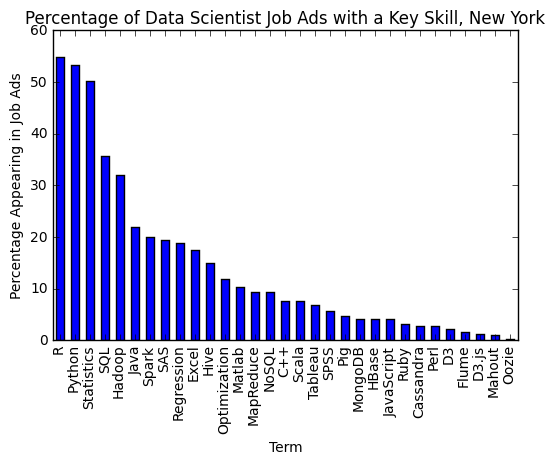

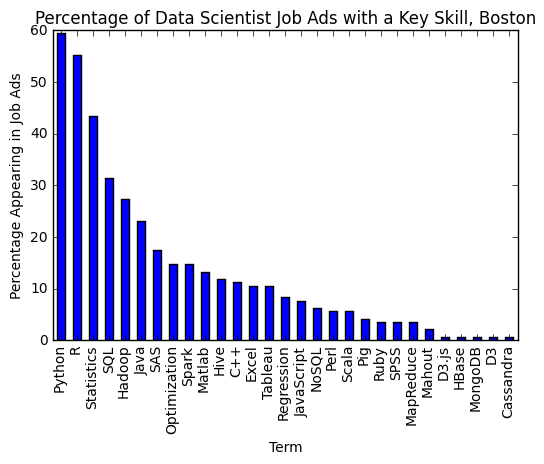

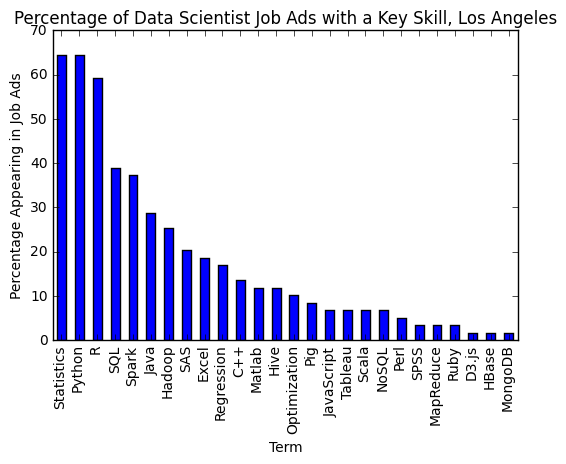

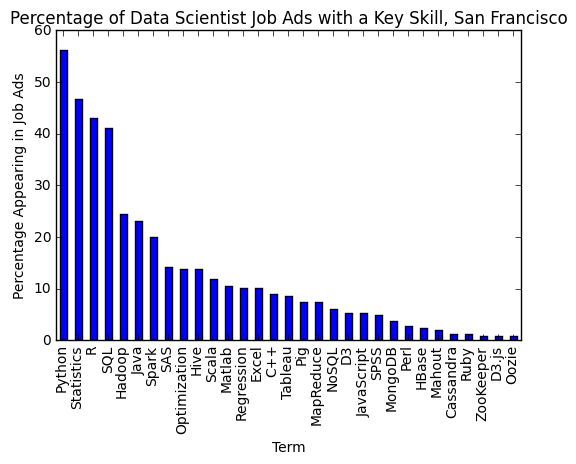

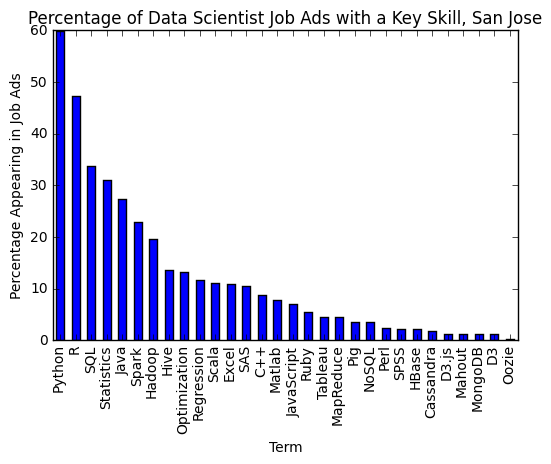

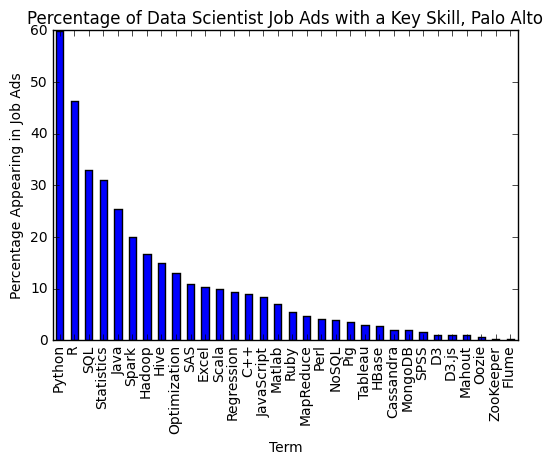

In [6]:
jobs = []
for i in range(len(cities)):
    jobs.append([cities[i], states[i], skills_info(city = cities[i], state = states[i])])
    sleep(1)
print jobs